# Example of top-hat jet run

__General instructions__: 
1. Set the working directory, where model output will be saved.  
__Important__: _do not use_ the same folder for multiple runs. H5 library will try to override the file and fail, if the file is loaded somewhere. 
2. Set jet strucutre, either numerically (give arrays of initial conditions for blastwaves) or analytical ejecta parameters (initial Energy, lorentz factor, opening engle, etc. of he jet)
3. Set simulation parameters and settings as a dictionary
4. Run the simulation
5. Analyze the result

---

In [14]:
import copy, os, gc, h5py, numpy as np, matplotlib.pyplot as plt
import PyBlastAfterglowMag as pba
from PyBlastAfterglowMag.wrappers import run_grb
from PyBlastAfterglowMag.utils import cgs 
from IPython.display import clear_output

In [15]:
# observational data for GRB170817A
class GRB170817A(object):
    
    def __init__(self):

        # load data
        times, freqs, data, errs = self._load_data()

        # unique freqs in the data
        ufreqs = np.unique(freqs)

        # concatenate the data for unique frequencies
        # data_ord = np.array([])
        # err_ord = np.array([])
        #
        # for frequency in freqs:
        #     # print(frequency)
        #     data_ord = np.concatenate([data_ord, data[freq == frequency]])
        #     err_ord = np.concatenate([err_ord, err[freq == frequency]])
        # assert np.shape(err_ord) == np.shape(data_ord)

        # print("--- Observations for GRB170817 ---")
        # print("Total amount of time: {}".format(len(times)))
        # print("Total amount of data: {}".format(len(data)))
        # print("Total amount of errs: {}".format(len(errs)))
        # print("Unique frequencies   ({})".format(len(ufreqs)))
        # print(ufreqs)
        # print("Data per frequency:")
        # for ifreq, freq in enumerate(ufreqs):
        #     print("freq={:.2e} N={:d}".format(freq, len(data[freq==freqs])))

        self.times = times
        self.data = data
        self.errs = errs
        self.freqs = freqs
        self.ufreqs = ufreqs

    def __call__(self, freq):
        return self.get(freq)

    def _load_data(self):
        """
            Chandra21 :: https://ui.adsabs.harvard.edu/abs/2020GCN.29055....1H/abstract
            Hajela:2020
        :return:
        """

        # Updated optical and X-ray data from Fong ea 2019, and Hajela ea 2019
        time = np.array([9.2, 14.9, 16.4, 17.4, 18.3, 18.7, 
                         19.4, 21.4, 22.4, 23.4, 24.2, 31.3, 
                         35.3, 39.2, 46.3, 53.3, 54.3, 57.2,
                         65.9, 66.6, 67.2, 72.2, 75.5, 75.5, 
                         77.6, 79.2, 80.1, 92.4, 93.1, 93.1, 
                         93.2, 97.1, 107., 107., 109., 109.,
                         111., 112., 115., 115., 115., 125., 
                         125., 126., 133., 137., 149., 150., 
                         152., 158., 161., 163., 163., 163.,
                         163., 165., 167., 170., 172., 183., 
                         197., 197., 207., 209., 216., 217., 
                         217., 217., 217., 218., 218., 222.,
                         229., 252., 257., 259., 261., 267., 
                         267., 273., 273., 289., 289., 294., 
                         297., 298., 320., 324., 328., 357.,
                         359., 362., 380., 489., 545., 580., 
                         581., 741., 767., 938., 1211 # Chandra21
                         ])  # time in days

        # flux in mJy
        data = np.array(
            [5.66e-04, 6.58e-04, 1.87e+01, 1.51e+01, 1.45e+01, 1.54e+01, 
             1.59e+01, 1.36e+01, 2.25e+01, 2.00e+01, 2.56e+01, 3.40e+01, 
             4.40e+01, 2.28e+01, 4.40e+01, 3.20e+01, 4.80e+01, 6.10e+01,
             1.48e+02, 9.80e+01, 4.26e+01, 5.80e+01, 3.59e+01, 3.96e+01, 
             7.70e+01, 4.50e+01, 4.17e+01, 3.17e+01, 9.80e+01, 7.00e+01, 
             2.60e+01, 1.99e+02, 1.27e+02, 5.32e+01, 2.96e-03, 1.09e-01,
             1.11e-01, 6.29e+01, 9.62e+01, 5.12e+01, 4.12e+01, 5.82e+01, 
             1.28e+02, 2.21e+02, 3.37e-03, 8.40e-02, 6.06e+01, 9.00e+01, 
             1.84e+02, 3.03e-03, 2.66e-03, 9.73e+01, 6.73e+01, 4.74e+01,
             3.96e+01, 9.10e-02, 5.79e+01, 1.13e-01, 8.50e-02, 2.11e+02, 
             7.59e+01, 8.93e+01, 4.20e+01, 8.20e-02, 3.63e+01, 6.05e+01, 
             4.17e+01, 3.26e+01, 2.47e+01, 6.47e+01, 6.30e-02, 3.97e+01,
             4.80e+01, 7.13e+01, 4.32e+01, 1.55e-03, 6.26e+01, 2.50e+01, 
             4.03e+01, 3.48e+01, 2.72e+01, 3.63e+01, 2.70e+01, 3.12e+01, 
             4.40e-02, 2.34e+01, 2.31e+01, 4.72e+01, 3.40e-02, 9.70e-04,
             1.55e+01, 2.70e-02, 3.79e+01, 1.48e+01, 5.90e+00, 1.80e+01, 
             3.54e-04, 2.68e-04, 4.90e+00, 1.95e-04, 3.46e-04 # Chandra21 3.46(+1.06 -1.31) e-15 erg/cm2/s
             ])

        # frequency of obs.
        freq = np.array([2.41e+17, 2.41e+17, 3.00e+09, 3.00e+09, 3.00e+09, 7.25e+09,
                         6.20e+09, 6.20e+09, 3.00e+09, 6.00e+09, 3.00e+09, 3.00e+09,
                         1.50e+09, 6.00e+09, 3.00e+09, 6.00e+09, 3.00e+09, 3.00e+09,
                         6.70e+08, 1.30e+09, 6.00e+09, 4.50e+09, 7.35e+09, 7.35e+09,
                         1.40e+09, 4.50e+09, 6.00e+09, 7.25e+09, 1.50e+09, 3.00e+09,
                         1.50e+10, 6.70e+08, 1.30e+09, 1.30e+09, 2.41e+17, 3.80e+14,
                         5.06e+14, 6.00e+09, 3.00e+09, 1.00e+10, 1.50e+10, 7.25e+09,
                         1.30e+09, 6.70e+08, 2.41e+17, 5.06e+14, 7.25e+09, 5.10e+09,
                         1.30e+09, 2.41e+17, 2.41e+17, 3.00e+09, 6.00e+09, 1.00e+10,
                         1.50e+10, 5.06e+14, 7.25e+09, 3.80e+14, 5.06e+14, 6.50e+08,
                         3.00e+09, 1.30e+09, 5.00e+09, 5.06e+14, 1.00e+10, 3.00e+09,
                         6.00e+09, 1.00e+10, 1.50e+10, 3.00e+09, 5.06e+14, 7.25e+09,
                         4.50e+09, 1.30e+09, 3.00e+09, 2.41e+17, 1.30e+09, 7.25e+09,
                         3.00e+09, 3.00e+09, 6.00e+09, 3.00e+09, 6.00e+09, 3.00e+09,
                         5.06e+14, 7.25e+09, 7.25e+09, 1.30e+09, 5.06e+14, 2.41e+17,
                         7.25e+09, 5.06e+14, 1.30e+09, 3.00e+09, 6.00e+09, 7.25e+09,
                         2.41e+17, 2.41e+17, 3.00e+09, 2.41e+17, 2.41e+17 # Chandra21
                         ])

        # error on flux
        err = np.array([1.70e-04, 1.30e-04, 6.30e+00, 3.90e+00, 3.70e+00, 4.80e+00,
                        5.50e+00, 2.90e+00, 3.40e+00, 3.10e+00, 2.90e+00, 3.60e+00,
                        1.00e+01, 2.60e+00, 4.00e+00, 4.00e+00, 6.00e+00, 9.00e+00,
                        2.20e+01, 2.00e+01, 4.10e+00, 5.00e+00, 4.30e+00, 7.00e+00,
                        1.90e+01, 7.00e+00, 4.70e+00, 4.30e+00, 1.40e+01, 5.70e+00,
                        4.40e+00, 1.60e+01, 1.80e+01, 4.50e+00, 2.60e-04, 1.70e-02,
                        1.90e-02, 3.20e+00, 8.00e+00, 3.40e+00, 1.90e+00, 5.00e+00,
                        2.10e+01, 1.90e+01, 4.00e-04, 1.80e-02, 4.30e+00, 3.00e+01,
                        1.90e+01, 2.60e-04, 2.70e-04, 1.13e+01, 4.10e+00, 3.60e+00,
                        2.00e+00, 1.60e-02, 6.90e+00, 1.90e-02, 1.70e-02, 3.40e+01,
                        5.20e+00, 1.39e+01, 1.20e+01, 2.00e-02, 3.60e+00, 7.50e+00,
                        7.50e+00, 4.00e+00, 3.10e+00, 2.70e+00, 1.80e-02, 7.20e+00,
                        6.00e+00, 6.70e+00, 5.80e+00, 1.90e-04, 7.00e+00, 4.10e+00,
                        2.70e+00, 4.90e+00, 2.10e+00, 3.90e+00, 2.80e+00, 3.60e+00,
                        1.40e-02, 4.20e+00, 4.00e+00, 1.28e+01, 1.10e-02, 1.90e-04,
                        5.00e+00, 7.00e-03, 1.18e+01, 2.90e+00, 1.90e+00, 4.20e+00,
                        9.00e-05, 9.00e-05, 1.80e+00, 7.00e-05, 1.3e-04 # Chandra21 3.46(+1.06 -1.31) e-15 erg/cm2/s
                        ])

        assert np.shape(time) == np.shape(freq)
        assert np.shape(data) == np.shape(err)

        data *= 1.e-29 # muJy -> ergs
        err *= 1.e-29 # muJy -> ergs

        return(time, freq, data, err) # [days, Hz, ergs, ergs]

    def get(self, freq):
        if not freq in self.ufreqs:
            raise NameError("freq: {} is not in data. Available are: {}".format(freq, self.ufreqs))
        mask = freq == self.freqs
        if len(mask) < 1:
            raise ValueError("Failed to get data for freq:{}".format(freq))
        return (self.times[mask], self.data[mask], self.errs[mask], np.zeros_like(self.times[mask]))

    def get_chandra(self):
        # Time since Merger (days) Fluxd (mJy) Err (mJy)
        data = np.array(
            [[2.19000, 1.40000e-07,  0.00000,     0.00000],
            [9.19679,  2.10000e-07,  8.72000e-08, -9.02000e-08],
            [15.3900,  6.44000e-07,  1.72000e-07, -1.20000e-07],
            [108.386,  2.21000e-06,  2.14000e-07, -2.02000e-07],
            [157.755,  2.41000e-06,  2.62000e-07, -2.11000e-07],
            [259.665,  1.07000e-06,  1.64000e-07, -1.55000e-07],
            [358.609,  9.12000e-07,  2.10000e-07, -1.73000e-07],
            [581.818,  2.14000e-07,  1.09000e-07, -7.72000e-08],
            [741.478,  1.26000e-07,  6.64000e-08, -5.39000e-08],
            [939.310,  1.54977e-07,  8.46022e-08, -6.26098e-08],
            [1234.11,  2.16000e-07,  5.45000e-08, -7.95000e-08]
        ])
        # return [day] [erg] [erg] [erg]
        errs = np.abs(data[:, 2:][:,::-1]).T
        # errs[:, 0] += data[:, 1]
        # errs[:, 1] += data[:, 1]
        uplims = np.zeros_like(data[:, 0], dtype=bool)
        return (data[:, 0], data[:, 1] / 1e3 / 1e23, errs / 1e3 / 1e23, uplims)##,  data[:, 3] * 1e3 * 1e23)

    def get_vla_3ggz(self):

        data = np.array(
            [
            # Time since Merger (days) Fluxd (mJy) Err (mJy)
              [3.34000,     0.032000002,       0.0000000],
              [16.4200,     0.018700000,    0.0063000000],
              [17.3900,     0.015100000,    0.0038999999],
              [18.3300,     0.014500000,    0.0037000000],
              [22.3600,     0.022500001,    0.0034000000],
              [24.2600,     0.025599999,    0.0029000000],
              [31.3200,     0.034000002,    0.0035999999],
              [46.2600,     0.044000000,    0.0040000002],
              [54.2700,     0.048000000,    0.0060000001],
              [57.2200,     0.061000001,    0.0089999996],
              [93.1300,     0.070000000,    0.0057000001],
              ##[196.790     0.081793795,    0.0081793800],
              [196.790,     0.073213301,    0.0066756521],
              [115.200,     0.075690837,     0.019037671],
              [115.200,      0.10307770,     0.011835645],
              ##[163.070,     0.096567894,     0.020509181],
              [163.070,     0.098128255,     0.018721838],
              [216.910,     0.068999998,     0.015000000],
              [220.000,     0.064700000,    0.0027000001],
              [256.760,     0.055000000,     0.012300000],
              [267.000,     0.040300000,    0.0027000001],
              [272.670,     0.043900002,     0.010500000],
              [288.610,     0.046399999,     0.011400000],
              [294.000,     0.031199999,    0.0035999999],
              [489.000,     0.014800000,    0.0029000000],
              [767.000,    0.0049000001,    0.0018000000],
              # [1221.50,    0.0054000001,      0.00000000],
              [1243.000,   2.86*1e-3,          0.99*1e-3], # https://arxiv.org/pdf/2103.04821.pdf
              [4.6*cgs.year/cgs.day,   4.5*1e-3,          1.1*1e-3] # https://arxiv.org/pdf/2205.14788.pdf
            ]
        )
        uplims = np.zeros_like(data[:, 0], dtype=bool)
        # data[:, 2] = 0.00200000
        uplims[-1] = True
        return (data[:, 0], data[:, 1] / 1e3 / 1e23, data[:, 2] / 1e3 / 1e23, uplims)
def plot_grb170817a_lc(ax, freq):
    o_obs = GRB170817A()
    if (freq == 3e9):
        x_obs, y_obs, yerr_obs, uplims = o_obs.get_vla_3ggz()
        lbl = r"GRB170817A VLA 3\,GHz"
    elif (freq == 2.41e+17):
        x_obs, y_obs, yerr_obs, uplims = o_obs.get_chandra()
        lbl = r"GRB170817A Chandra 1\,keV"
    elif freq in o_obs.freqs:
        x_obs, y_obs, yerr_obs, uplims = o_obs.get(freq)
        lbl = "GRB170817A"
    else:
        return
    # plotdic = {}
    plotdic = {
        "x_vals": x_obs, "y_vals": y_obs * 1e23 * 1e3, "yerr_vals": yerr_obs * 1e23 * 1e3,
        "plot": {'ecolor': 'gray', 'mec': 'gray',  "uplims":uplims,
                 'marker': 'o', 'markersize': 8,
                 "capsize": 2, "linestyle": "None", 'mfc': "white",
                 "label": lbl, "zorder": 100},
        "legend": {"fancybox": False, "loc": 'lower left',
                   # "bbox_to_anchor":(1.0, 0.0),  # loc=(0.0, 0.6),  # (1.0, 0.3), # <-> |
                   "shadow": "False", "ncol": 1, "fontsize": 12,
                   "framealpha": 0., "borderaxespad": 0., "frameon": False}
    }
    tmp = copy.deepcopy(plotdic)
    obs_times, obs_fluxes, obs_errs = tmp["x_vals"], tmp["y_vals"], tmp["yerr_vals"]
    tmptmp = copy.deepcopy(plotdic["plot"])
    if "label" in tmptmp.keys():
        lbl = tmptmp["label"]
        del tmptmp["label"]
    _l = ax.errorbar(obs_times, obs_fluxes, yerr=obs_errs, **tmptmp)
    # tmptmp["marker"] = "v"
    # for ulim in uplims:
    #     ax.plot(ulim)
    if "label" in plotdic["plot"].keys():
        obs_legend = copy.deepcopy(tmp["legend"])
        obs_legend["loc"] = "lower right"
        leg2 = ax.legend([_l], [lbl], **obs_legend)
        ax.add_artist(leg2)

## Setting up a simulation for gaussian jet 

A gaussian jet has only several angular layers. Their number, `n_layers_a` is the main resolution parameter. Increasing it significantly increases sky map resolution but severly hiders the computational spead. By default it is set to 21. 

- __Structure__: Analytic guassian structure is characterized by its core energy `Eiso_c`, Core Lorentz factor `Gamma0c` and core opening angle `theta_c` and wind opening angle `theta_w` (3 parameters)   
- __Environemnt__: Assume constant density ISM `n_ism` (1 parameter)  
- __Observer__: The observer is located at a certain distance `d_l` (redshift `z`), and the jet axis has a certain angle with respect to the line of sight `theta_obs` (3 parameters)  
- __Microphysics__: Shock microphysics within one shock requires 3 parameters (simplest form) for fractions of internal energy in accelerated particles `eps_e_fs` and magnetic fields `eps_b_fs` and power-law slope of the electron distribution `p_fs` (3 parameters)  

Thus, a tophat jet with forward shock (FS) only needs 11 free parameters:
- `[ Eiso_c, Gamma0c, theta_c, theta_w, n_ism, theta_obs, eps_e_fs, eps_b_fs, p_fs, d_l, z ]`   
(however, `d_l` and `z` are connected and the only need is theoretically free)

In [16]:
# Define jet structure (analytic; gaussian) -- 3 free parameters 
struct = dict(
    struct="gaussian", # type of the structure tophat or gaussian
    Eiso_c=np.power(10, 54.1),#1.e52,    # isotropic equivalent energy of the burst 
    Gamma0c=300.,    # lorentz factor of the core of the jet 
    M0c=-1.,         # mass of the ejecta (if -1 -- iferr from Eiso_c and Gamma0c)
    theta_c=np.deg2rad(3.50), # 0.085,     # half-opening angle of the core of the jet
    theta_w=np.deg2rad(25.),#0.2618      # half-opening angle of the winds of the jet
    n_layers_a=21   # resolution of the jet (number of individual blastwaves)
)

# set model parameters
P = dict(
        # main model parameters; Uniform ISM -- 2 free parameters
        main=dict(
            d_l= 1.27e+26, # luminocity distance to the source [cm]
            z = 0.0099,   # redshift of the source (used in Doppler shifring and EBL table)
            n_ism=np.power(10, -1.60),#0.00031,    # ISM density [cm^-3] (assuming uniform)
            theta_obs=np.deg2rad(20.8),#0.3752, # observer angle [rad] (from pol to jet axis)  
            rtol=5e-7,   # relative tolerance for adaptive quadrature that compute observed emission
            lc_freqs='array logspace 1e8 1e29 96', # frequencies for light curve calculation
            lc_times='array logspace 3e3 1e10 128', # times for light curve calculation
            tb0=3e2,tb1=1e14,ntb=1000, # burster frame time grid boundary, resolution, for the simulation
        ),
        # ejecta parameters; FS only -- 3 free parameters 
        grb=dict(
            structure=struct, # structure of the ejecta
            eps_e_fs=np.power(10,-3.42),#0.0708,     # microphysics - FS - frac. energy in electrons
            eps_b_fs=np.power(10,-4.02),#0.0052,   # microphysics - FS - frac. energy in magnetic fields
            p_fs=2.10, #2.16,         # microphysics - FS - slope of the injection electron spectrum
            do_lc='yes',      # task - compute light curves
            # save_spec='yes' # save comoving spectra 
            # method_synchrotron_fs = 'Joh06',
            # method_ne_fs = 'usenprime',
            # method_ele_fs = 'analytic',
            # method_comp_mode = 'observFlux'
        )
)

In [17]:
P["grb"]["method_ssc_fs"] = "numeric"
P["grb"]["method_ele_fs"] = "numeric"
P["grb"]["method_pp_fs"] = "numeric"

# run the simulation
pba_run_pp = run_grb(
    working_dir=os.getcwd() + '/tmp_gauss_pp/', # directory to save/load from simulation data
    P=P,                     # all parameters 
    run=False,                # run code itself (if False, it will try to load results)
    path_to_cpp="/home/vsevolod/Work/GIT/GitHub/PyBlastAfterglowMag/src/pba.out",
    loglevel="err",
    process_skymaps=False 
)
clear_output(wait=False)
# 43 minutes

In [10]:
import afterglowpy as grb 
class RunAfterglowpy:
    def __init__(self, P:dict):
        # afterglopy also need a dict as a parameter set; but a different one
        struct = P["grb"]["structure"]
        pp = P["grb"]
        Z = {
            'jetType':     grb.jet.TopHat if struct["struct"] == "tophat" else grb.jet.Gaussian,     # Top-Hat jet
            'specType':    0,                  # Basic Synchrotron Spectrum
            'counterjet':  1,
            'spread':      7, #if pba.GRB.opts["method_spread"] != "None" else -1,
            'n0':          P["main"]["n_ism"],    # circumburst density in cm^{-3}
            'thetaObs':    P["main"]["theta_obs"],   # Viewing angle in radians
            'd_L':         P["main"]["d_l"], # Luminosity distance in cm
            'z':           P["main"]["z"],   # redshift
            'E0':          struct["Eiso_c"], # Isotropic-equivalent energy in erg
            'g0':          struct["Gamma0c"],
            'thetaCore':   struct["theta_c"],    # Half-opening angle in radians
            'thetaWing':   struct["theta_w"],
            'p':           pp["p_fs"],    # electron energy distribution index
            'epsilon_e':   pp["eps_e_fs"],    # epsilon_e
            'epsilon_B':   pp["eps_b_fs"],   # epsilon_B
            'xi_N':        1.0,    # Fraction of electrons accelerated
        }
        # run spectrum
        times_set = P["main"]["lc_times"]
        times = np.logspace(np.log10(float(times_set.split()[-3])),
                            np.log10(float(times_set.split()[-2])),
                            int(times_set.split()[-1]))
        freq_set = P["main"]["lc_freqs"]
        freqs = np.logspace(np.log10(float(freq_set.split()[-3])),
                            np.log10(float(freq_set.split()[-2])),
                            int(freq_set.split()[-1]))
        # all_times = np.concatenate([times for _ in range(len(freqs))])
        # all_freqs = np.concatenate([times for _ in range(len(freqs))])
        all_times, all_freqs = [], []
        for it, t in enumerate(times):
            for ifreq, freq in enumerate(freqs):
                all_times.append(t)
                all_freqs.append(freq)
        all_times = np.array(all_times)
        all_freqs = np.array(all_freqs)
        # takes equal size arrays to compute lightcurves
        Fnu = grb.fluxDensity(all_times, all_freqs, **Z)
        Fnu = np.reshape(Fnu, newshape=(len(times),len(freqs)))
        self.spec = Fnu
        self.freqs = freqs
        self.times = times

    def get_lc(self, freq:float):
        idx = (np.abs(self.freqs - freq)).argmin()
        return self.spec[:,idx]
    
    def get_spec(self, time:float):
        idx = (np.abs(self.times - time)).argmin()
        return self.spec[idx,:]
afgpy = RunAfterglowpy(P=P)

In [11]:
import jetsimpy
class RunJetsimpy:
    def __init__(self, P:dict):
        struct = P["grb"]["structure"]
        # jetsimpy also need a dict as a parameter set; but a different one
        pp = dict(
            Eiso = struct["Eiso_c"],        # (Jet) Isotropic equivalent energy
            lf = struct["Gamma0c"],           # (Jet) Lorentz factor
            # theta_c = struct["theta_c"],      # (Jet) half opening angle
            n0 = P["main"]["n_ism"],             # (ISM) constant number density
            k = 0.0,            # (ISM) wind power index
            A = 0,              # (ISM) wind amplitude
            eps_e = P["grb"]["eps_e_fs"],        # (Radiation) epsilon_e
            eps_b = P["grb"]["eps_b_fs"],       # (Radiation) epsilon_b
            p = P["grb"]["p_fs"],           # (Radiation) electron power index
            theta_v = P["main"]["theta_obs"],      # (Radiation) viewing angle
            d = P["main"]["d_l"]/cgs.pc/1e6,         # (radiation) distance (Mpc)
            z = P["main"]["z"],            # (radiation) redshift
            xi_N = 1.0,       # (radiation customized) total fraction of accelerated electrons
            b = 0,              # (radiation) magnetic field anisotropy
        )
        # this code does not take structure parameters, but an actual structure itself
        if struct["struct"] == "tophat":
            theta = np.linspace(0, np.pi, 1000)
            Eiso = np.full_like(theta, pp["Eiso"]) # P["Eiso"] * np.exp(- 0.5 * (theta / P["theta_c"]) ** 2)
            lf = np.full_like(theta, pp["lf"]) #(P["lf"] - 1) * np.exp(- 0.5 * (theta / P["theta_c"]) ** 2) + 1
            lf[theta > struct["theta_w"]] = 0.
            Eiso[theta > struct["theta_w"]] = 0.
        elif struct["struct"] == "gaussian":
            theta = np.linspace(0, np.pi, 1000)
            Eiso = pp["Eiso"] * np.exp(- 0.5 * (theta / struct["theta_c"]) ** 2)
            lf = (pp["lf"] - 1) * np.exp(- 0.5 * (theta / struct["theta_c"]) ** 2) + 1
            # Eiso[theta > struct["theta_w"]] = 0.
        else:
            raise KeyError("structure is not recognized")
            
        # do light curve
        if True:
            jet1 = jetsimpy.Afterglow(
                theta,           # array of theta
                Eiso,            # array of isotropic equivalent energy
                lf,              # array of initial lorentz factor
                # 0.,
                pp["A"],          # scale of wind density
                pp["n0"],         # constant number density
                tmin=P["main"]["tb0"],
                tmax=P["main"]["tb1"],
                spread=True,#pba.GRB.opts["method_spread"] != "None",    # (default = True) with/without spreading effect
                coast=True,      # (default = True) with/without coasting. If this is "False", the initial lorentz factor data will be omitted.
            )
            times_set = P["main"]["lc_times"]
            times = np.logspace(np.log10(float(times_set.split()[-3])),
                            np.log10(float(times_set.split()[-2])),
                            int(times_set.split()[-1]))
            freq_set = P["main"]["lc_freqs"]
            freqs = np.logspace(np.log10(float(freq_set.split()[-3])),
                            np.log10(float(freq_set.split()[-2])),
                            int(freq_set.split()[-1]))
            Fnu = []
            for ifreq, freq in enumerate(freqs):
                lc = jet1.FluxDensity(
                    times,           # [second] observing time span
                    freq,                # [Hz]     observing frequency
                    copy.deepcopy(pp),                 # parameter dictionary for radiation
                    rtol=1e-2,         # (default=1e-2) integration error tolerance
                    model="sync",      # default radiation model
                )
                Fnu.append(lc)
            spec = np.reshape(np.array(Fnu),newshape=(len(freqs),len(times))).T
            self.times = times
            self.freqs = freqs
            self.spec = spec
    
    def get_lc(self, freq:float):
        idx = (np.abs(self.freqs - freq)).argmin()
        return self.spec[:,idx]
    
    def get_spec(self, time:float):
        idx = (np.abs(self.times - time)).argmin()
        return self.spec[idx,:]
jetpy = RunJetsimpy(P=P)

In [12]:
def plot_lcs(ejecta:pba.interface.Ejecta,ejecta_def:pba.interface.Ejecta | None, freqs:tuple, 
             afgpy:RunAfterglowpy | None, jetpy:RunJetsimpy | None, obs:bool=True):
    # get light curves
    times = ejecta.get_lc_times()
    # freqs = ejecta.get_lc_freqs()
    fig, axes = plt.subplots(nrows=1,ncols=len(freqs),figsize=(12,3),layout='constrained')
    for i, freq in enumerate(freqs):
        lc = ejecta.get_lc(freq=freq)
        axes[i].plot(times/cgs.day, lc,color='black')
        if not ejecta_def is None:
            lc = ejecta_def.get_lc(freq=freq)
            axes[i].plot(times/cgs.day, lc,color='gray',ls=':', label='Default')
        if not afgpy is None:
            lc = afgpy.get_lc(freq=freq)
            axes[i].plot(times/cgs.day, lc,color='blue',ls=':', label='afterglowpy')
        if not jetpy is None:
            lc = jetpy.get_lc(freq=freq)
            axes[i].plot(times/cgs.day, lc,color='green',ls=':', label='jetsimpy')
        if obs:
            plot_grb170817a_lc(ax=axes[i], freq=freq)
        axes[i].set_xscale('log')
        axes[i].set_yscale('log')
        axes[i].set_ylim(1e-4*np.max(lc), 10*np.max(lc))
        axes[i].set_title(f"log(freq)={np.log10(freq)}")
        axes[i].set_xlabel("time [day]")
        axes[i].grid(ls=':')
    axes[0].set_ylabel("Flux density [mJy]")
    axes[-1].legend()
    plt.show()
def plot_spectra(ejecta:pba.interface.Ejecta,ejecta_def:pba.interface.Ejecta | None,times:tuple,
                 afgpy:RunAfterglowpy | None, jetpy:RunJetsimpy | None):
    # get light curves
    # times = ejecta.get_lc_times()
    freqs = ejecta.get_lc_freqs()
    fig, axes = plt.subplots(nrows=1,ncols=len(times),figsize=(12,3),layout='constrained')
    for i, time in enumerate(times):
        spec = ejecta.get_lc(time=time)
        spec = freqs*spec*1e-3*1e-23
        axes[i].plot(freqs, spec,color='black')
        if not ejecta_def is None:
            spec = ejecta_def.get_lc(time=time)
            spec = freqs*spec*1e-3*1e-23
            axes[i].plot(freqs, spec,color='gray',ls=':', label='Default')
        if not afgpy is None:
            spec = afgpy.get_spec(time=time)
            spec = freqs*spec*1e-3*1e-23
            axes[i].plot(freqs, spec,color='blue',ls=':', label='afterglowpy')
        if not jetpy is None:
            spec = jetpy.get_spec(time=time)
            spec = freqs*spec*1e-3*1e-23
            axes[i].plot(freqs, spec,color='green',ls=':', label='jetsimpy')
        axes[i].set_xscale('log')
        axes[i].set_yscale('log')
        axes[i].set_ylim(1e-5*np.max(spec), 10*np.max(spec))
        axes[i].set_title(f"log(time)={np.log10(time)}")
        axes[i].set_xlabel("freq [Mz]")
        axes[i].grid(ls=':')
        axes[-1].legend()
    axes[0].set_ylabel("nuFnu [erg s-1 cm-2]")
    plt.show()

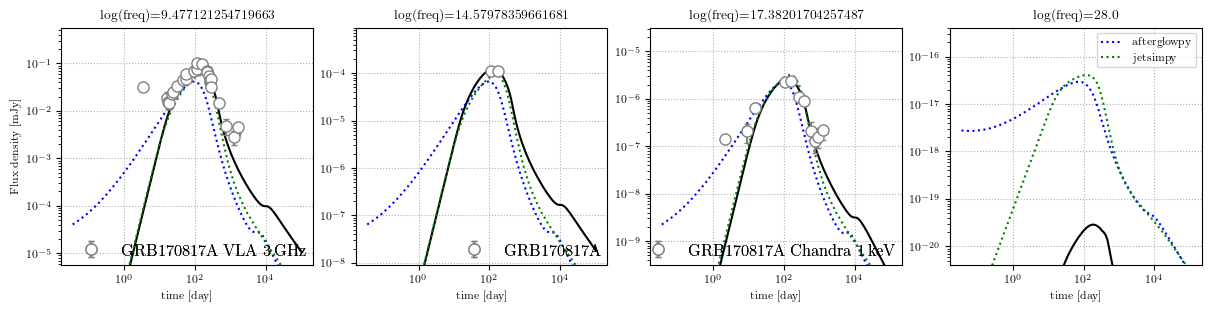

In [13]:
# plot light curves
plot_lcs(ejecta=pba_run_pp.GRB, ejecta_def=None, freqs=(3e9, 3.80e+14, 2.41e+17, 1e28), afgpy=afgpy, jetpy=jetpy)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


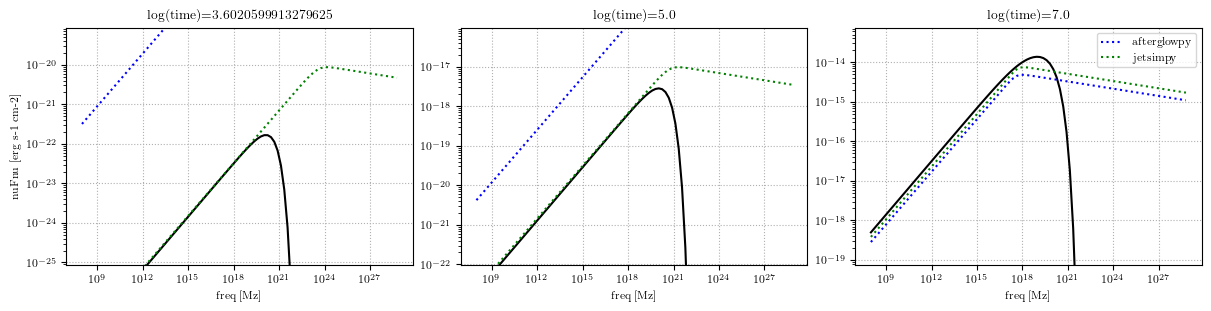

In [10]:
plot_spectra(ejecta=pba_run_pp.GRB,ejecta_def=None,times=(4e3, 1e5, 1e7),afgpy=afgpy,jetpy=jetpy)

## Full Model (FS & RS; SSA; SSC; PP)

In [18]:
P_fsrs=copy.deepcopy(P)

# Add high energy part (SSC and PP)
P_fsrs["grb"]["method_ssc_fs"] = "numeric" # from none -> numeric
P_fsrs["grb"]["method_pp_fs"] = "numeric" # from none -> numeric

# Add SSA (low energy part absorption)
P_fsrs["grb"]["use_ssa_fs"] = "yes" # from none -> numeric
P_fsrs["grb"]["use_ssa_rs"] = "yes" # from none -> numeric

# Include Reverse shock 
P_fsrs["grb"]["do_rs"] = "yes" # from none -> numeric
P_fsrs["grb"]["bw_type"] = "fsrs" # from none -> numeric

# Microphsyics for reverse shock
P_fsrs["grb"]["eps_e_rs"] = 0.01
P_fsrs["grb"]["eps_b_rs"] = 0.001
P_fsrs["grb"]["p_rs"] = 2.4

P_fsrs["grb"]["do_skymap"] = "yes"
P_fsrs["main"]["skymap_freqs"] = "array 4.5e9"
P_fsrs["main"]["skymap_times"] = "array logspace 1e3 1e8 100"

skymap_conf=dict(nx=128, ny=64, extend_grid=2, fwhm_fac=0.5, lat_dist_method="integ",
                intp_filter=dict(type="gaussian", size=2, sigma=1.5, mode='reflect'),  # "gaussian"
                hist_filter=dict(type="gaussian", size=2, sigma=1.5, mode='reflect'))
P_fsrs["grb"]["skymap_conf"] = skymap_conf

working_dir = os.getcwd() + '/tmp_gauss_fsrs_ssa_ssc_pp/' # new working directory for clarity

# run the code and get the instance of a python interfact to the code intput/output 
pba_run_fsrs_ssa_ssc_pp = run_grb(
    working_dir=working_dir, # directory to save/load from simulation data
    P=P_fsrs,                     # all parameters 
    run=False,                # run code itself (if False, it will try to load results)
    path_to_cpp="/home/vsevolod/Work/GIT/GitHub/PyBlastAfterglowMag/src/pba.out",
    loglevel="err",
    process_skymaps=True 
)
clear_output(wait=False)
# 116 minutes

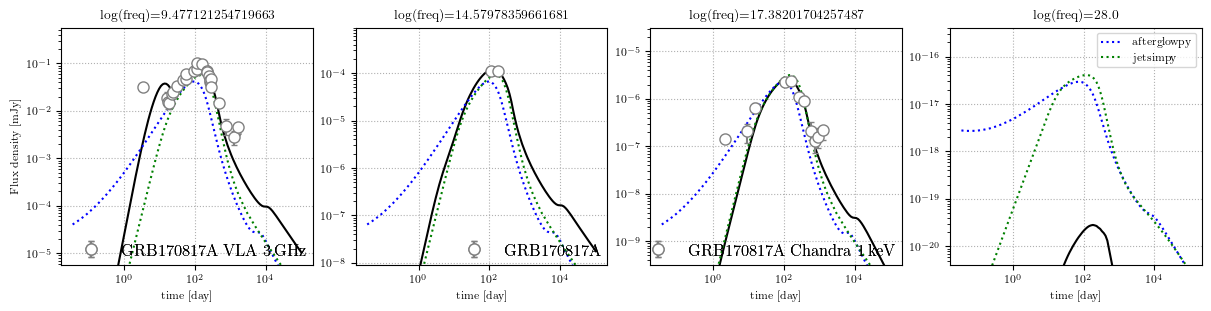

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


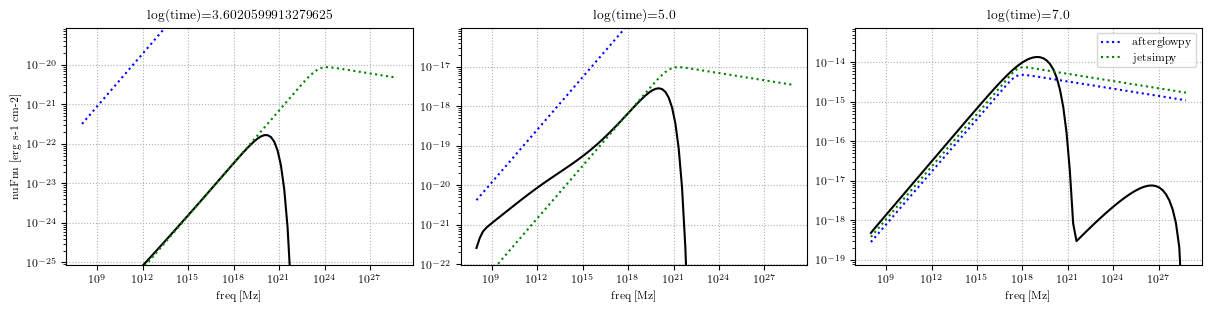

In [19]:
plot_lcs(ejecta=pba_run_fsrs_ssa_ssc_pp.GRB, ejecta_def=None, freqs=(3e9, 3.80e+14, 2.41e+17, 1e28), afgpy=afgpy, jetpy=jetpy)
plot_spectra(ejecta=pba_run_fsrs_ssa_ssc_pp.GRB,ejecta_def=None,times=(4e3, 1e5, 1e7),afgpy=afgpy,jetpy=jetpy)

# Skymaps

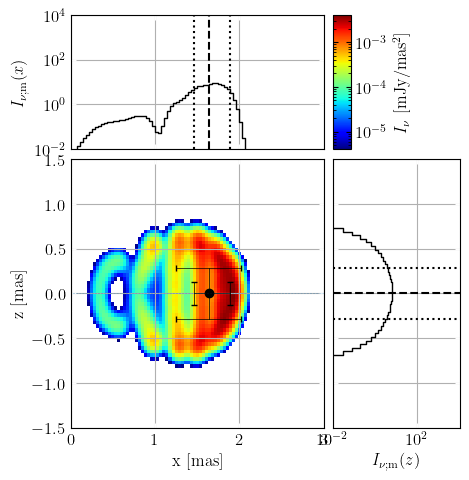

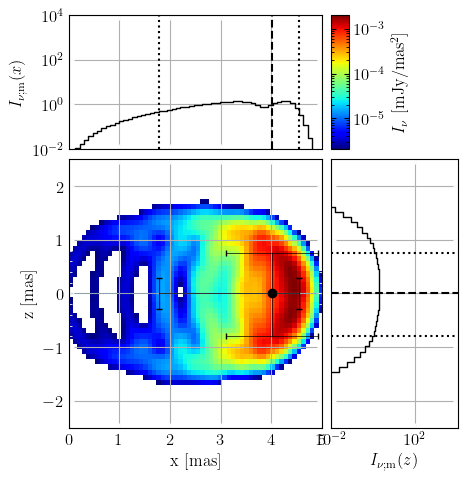

In [20]:
config = {
        "gridspec": {
            "width_ratios": (4, 2), "height_ratios": (2, 4),
            "left": 0.14, "right": 0.95, "bottom": 0.1, "top": 0.96, "wspace": 0.05, "hspace": 0.05
        },
        "figname": "out", "paperpath": os.getcwd()+'/', "figfpath": os.getcwd()+'/', "save_pdf": False, "save_figs": False,
        "show_figs": True,
        "grid": False,
        "figsize": (4.8, 4.8),
        "type":"hist",
        "cm": {"color": 'black', "marker": "o"},
        "ysize": {"capsize": 2, "color": "black", "lw": 0.5},
        "xsize": {"capsize": 2, "color": "black", "lw": 0.5},
        "pcolormesh": {"cmap": 'jet', "set_under": 'white', "set_over": None, "set_rasterized": True,
                       "norm": ("log", "0.001max", "1max"), "facecolor": None, "alpha": 1.0, "isnan": np.nan},
        "xlim": (-0., 3.0), "ylim": (-1.5, 1.5),
        "title": {"title": "time_fluxratio"},  # "time_fluxratio"
        "cbar_title": r'$I_{\nu}^{\rm w}/I_{\nu}^{\rm w/o}$',
        "xlabel": "x [mas]", "ylabel": "z [mas]",
        "histx_backgound_color": "white",
        "histy_backgound_color": "white",
        "plot_grids":True,
        "histx_lim":(1e-2,1e4),
        "histy_lim":(1e-2,1e4)
    }

# get skymap 
skymap=pba_run_fsrs_ssa_ssc_pp.GRB.get_skymap(time=75.*cgs.day, freq=4.5e9)

pba.skymap_plotting_tools.full_plot_skymap_with_hists(
    skymap=skymap, conf=config
)


config["xlim"] = (-0., 5.0)
config["ylim"] = (-2.5, 2.5)

skymap=pba_run_fsrs_ssa_ssc_pp.GRB.get_skymap(time=230.*cgs.day, freq=4.5e9)
pba.skymap_plotting_tools.full_plot_skymap_with_hists(
    skymap=skymap, conf=config
)

# Radio Sky Map Evolution

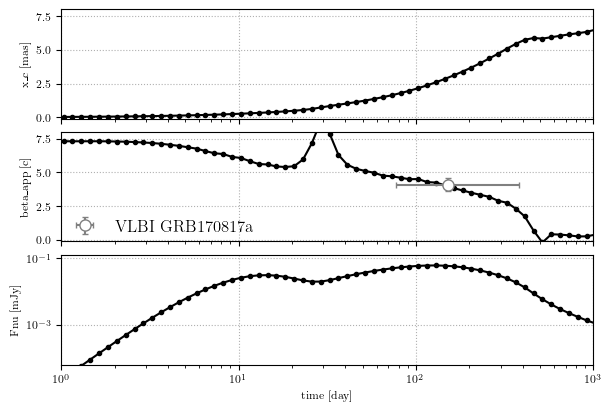

In [25]:
def plot_skymap_prop_evoluton(ejecta:pba.Ejecta, freq:float):
    times = ejecta.get_skymap_times() 
    skymaps = [ejecta.get_skymap(time=t, freq=freq) for t in times]
    xcs = [skymap.xc for skymap in skymaps]
    delta_x = [abs(skymap.x2-skymap.x1) for skymap in skymaps]
    fluxes = [skymap.flux for skymap in skymaps]

    beta_app = np.diff(xcs)*cgs.rad2mas / times[1:]# / cgs.c
    #print(beta_app)

    fig,axes = plt.subplots(ncols=1,nrows=3,sharex='all',layout='constrained',figsize=(6,4))
    
    i = 0
    axes[i].plot(times/cgs.day, xcs, color='black', ls='-', marker='.')
    axes[i].set_ylabel("x_c [mas]")
    axes[i].set_ylim(-.1,8)

    i+=1
    axes[i].plot(times[1:]/cgs.day, beta_app, color='black', ls='-', marker='.')
    axes[i].set_ylabel("beta_app [c]")
    axes[i].set_ylim(-.1,8)
    #4.1±0.5 # Mooley et al 2018
    axes[i].errorbar([(230+75)/2], [4.1], 
                     xerr=np.array([75,230]).reshape(-1,1), 
                     yerr=np.array([0.5,0.5]).reshape(-1,1), 
                     **{'ecolor': 'gray', 'mec': 'gray',  
                        'marker': 'o', 'markersize': 8,
                        "capsize": 2, "linestyle": "None", 'mfc': "white",
                        "label": "VLBI GRB170817a", "zorder": 100})
    axes[i].legend(**{"fancybox": False, "loc": 'lower left',
                   # "bbox_to_anchor":(1.0, 0.0),  # loc=(0.0, 0.6),  # (1.0, 0.3), # <-> |
                   "shadow": "False", "ncol": 1, "fontsize": 12,
                   "framealpha": 0., "borderaxespad": 0., "frameon": False})
    
    # i+=1
    # axes[i].plot(times/cgs.day, delta_x, color='black', ls='-', marker='.')
    # axes[i].set_ylabel("delta_x [mas]")
    i+=1
    axes[i].plot(times/cgs.day, fluxes, color='black', ls='-', marker='.')
    axes[i].set_ylabel("Fnu [mJy]")
    axes[i].set_yscale("log")
    axes[i].set_ylim(max(fluxes)*1e-3,max(fluxes)*2)

    for ax in axes:
        ax.set_xscale('log')
        ax.grid(ls=':')
        ax.set_xlim(1,1e3)
    axes[-1].set_xlabel('time [day]')
plot_skymap_prop_evoluton(ejecta=pba_run_fsrs_ssa_ssc_pp.GRB,
                          freq=4.5e9)